In [1]:
# Imports
import numpy as np
from PIL import Image
import requests
from io import BytesIO

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from IPython.display import  display

from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


In [0]:
# Hyperparams
ITERATIONS = 10
# colored
CHANNELS = 3
# unified images size
IMAGE_SIZE = 500
IMAGE_WIDTH = IMAGE_SIZE
IMAGE_HEIGHT = IMAGE_SIZE


IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]
CONTENT_WEIGHT = 0.02
STYLE_WEIGHT = 4.5
TOTAL_VARIATION_WEIGHT = 0.995
TOTAL_VARIATION_LOSS_FACTOR = 1.25

In [0]:
# Paths
input_image_path = "input.png"
style_image_path = "style.png"
output_image_path = "output.png"
combined_image_path = "combined.png"

# San Francisco
#san_francisco_image_path = "https://www.economist.com/sites/default/files/images/print-edition/20180602_USP001_0.jpg"
san_francisco_image_path = "https://cdn3.vectorstock.com/i/1000x1000/82/32/letter-r-handwritten-by-dry-brush-rough-strokes-vector-15788232.jpg"

# Warsaw by Tytus Brzozowski, http://t-b.pl
#tytus_image_path = "https://thumbs.dreamstime.com/z/islamic-art-arabic-letters-34637281.jpg"
tytus_image_path = "https://st2.depositphotos.com/5504382/10575/v/450/depositphotos_105756840-stock-illustration-squared-keffiyeh-vector-pattern-with.jpg"
#tytus_image_path = "http://meetingbenches.com/wp-content/flagallery/tytus-brzozowski-polish-architect-and-watercolorist-a-fairy-tale-in-warsaw/tytus_brzozowski_13.jpg"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


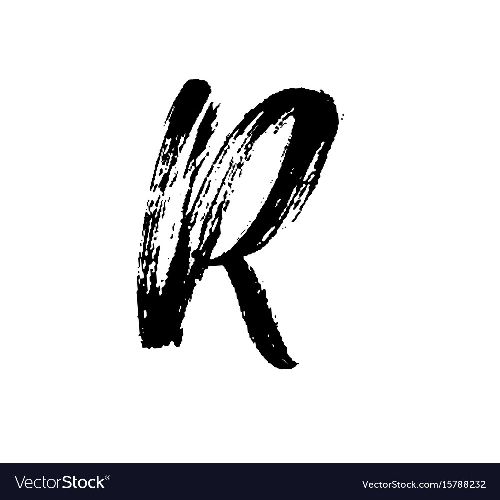

In [5]:
#Input visualization 
input_image = Image.open(BytesIO(requests.get(san_francisco_image_path).content))
input_image = input_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
input_image.save(input_image_path)
input_image

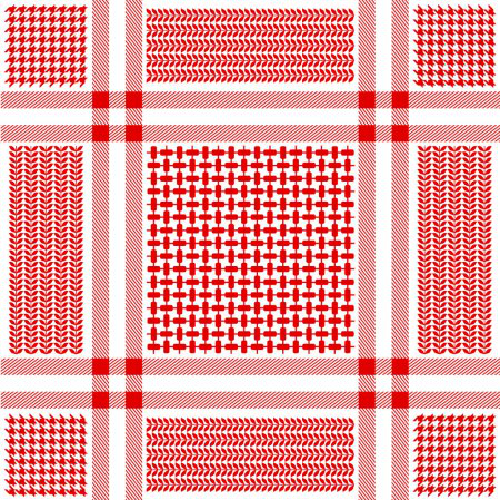

In [6]:
# Style visualization 
style_image = Image.open(BytesIO(requests.get(tytus_image_path).content))
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image.save(style_image_path)
style_image

In [0]:

# display(style_image)
# #print(imageName)

In [0]:
# Data normalization and reshaping from RGB to BGR
# we will do 2 steps:
# 1- it substracts the average r,g and b values as it was done by the people who created imagenet vgg16 model 
# 2- it changes the order of the channels from rgb to bgr 
# (I believe because the software used by the Imagenet competitors uses
#  OpenCV to load images which uses BGR as the default channel order).

#input image
input_image_array = np.asarray(input_image, dtype="float32")
input_image_array = np.expand_dims(input_image_array, axis=0)
#substracts the average
input_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
input_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
input_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
#rotate image colors (BGR -> RGB)
input_image_array = input_image_array[:, :, :, ::-1]


# style image
style_image_array = np.asarray(style_image, dtype="float32")
style_image_array = np.expand_dims(style_image_array, axis=0)
style_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
style_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
style_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
style_image_array = style_image_array[:, :, :, ::-1]


In [9]:
# Model
input_image = backend.variable(input_image_array)
style_image = backend.variable(style_image_array)
combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_SIZE, 3))
input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0)
model = VGG16(input_tensor=input_tensor, include_top=False)





58892288/58889256 [==============================] - 1s 0us/step








In [10]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layers = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = "block2_conv2"
layer_features = layers[content_layer]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = backend.variable(0.)
loss += CONTENT_WEIGHT * content_loss(content_image_features,
                                      combination_features)

In [0]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [0]:
def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss += (STYLE_WEIGHT / len(style_layers)) * style_loss

In [0]:
def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)

In [14]:
outputs = [loss]
outputs += backend.gradients(loss, combination_image)

def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Iteration 0 completed with loss 605662412800
Iteration 1 completed with loss 330791256064
Iteration 2 completed with loss 258240888832
Iteration 3 completed with loss 231349813248
Iteration 4 completed with loss 217858932736
Iteration 5 completed with loss 209867358208
Iteration 6 completed with loss 203755618304
Iteration 7 completed with loss 198852984832
Iteration 8 completed with loss 195214376960
Iteration 9 completed with loss 192436994048


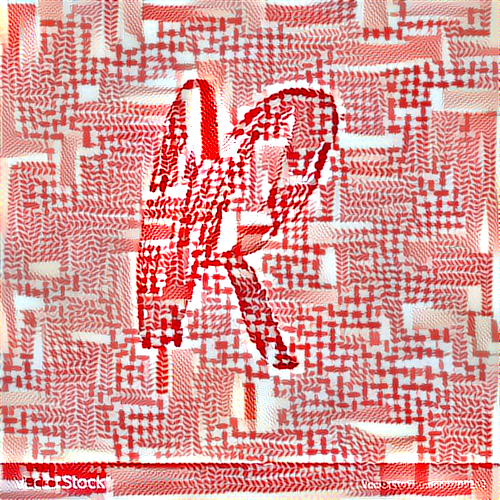

In [15]:
x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

for i in range(ITERATIONS):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))

    # xi = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    # xi = xi[:, :, ::-1]
    # xi[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
    # xi[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
    # xi[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
    # xi = np.clip(xi, 0, 255).astype("uint8")
    # output_image = Image.fromarray(xi)
    # output_image.save(output_image_path)
    # display(output_image)
    # output_image
    
x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
x = x[:, :, ::-1]
x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save(output_image_path)
output_image

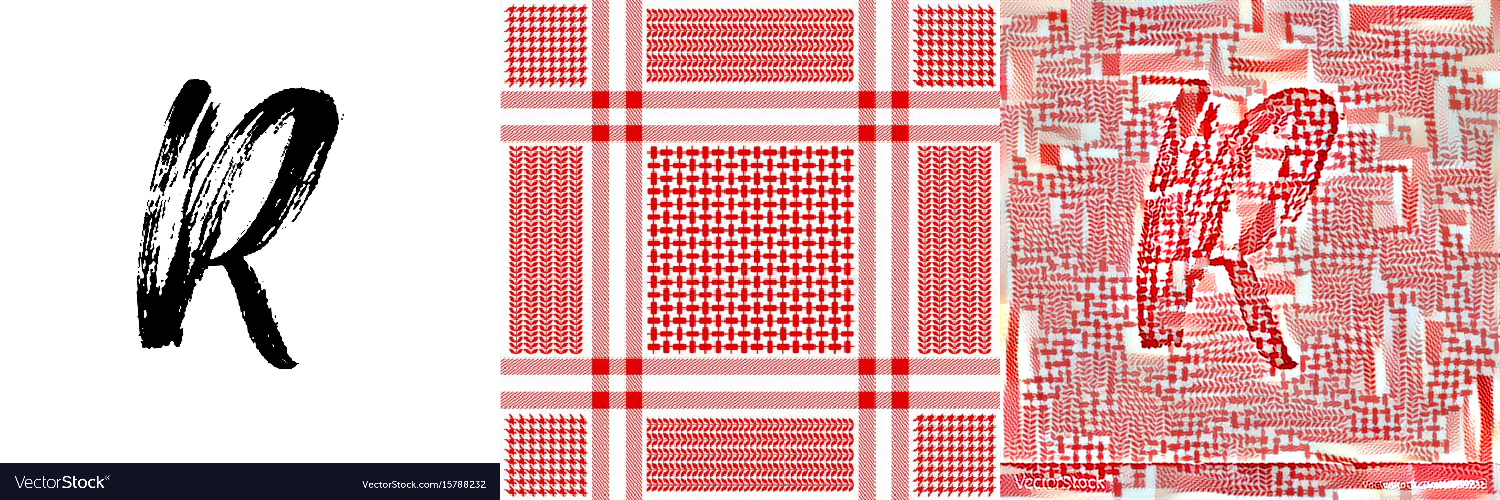

In [62]:
# Visualizing combined results
combined = Image.new("RGB", (IMAGE_WIDTH*3, IMAGE_HEIGHT))
x_offset = 0
for image in map(Image.open, [input_image_path, style_image_path, output_image_path]):
    combined.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
combined.save(combined_image_path)
combined

In [0]:
# from google.colab import files
# files.download('output.png')

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:

import numpy as np

# opencv loads the image in BGR, convert it to RGB
img = cv2.cvtColor(cv2.imread("/content/drive/My Drive/Colab Notebooks/datasets/output.png"),cv2.COLOR_BGR2RGB)
lower_white = np.array([220, 220, 220], dtype=np.uint8)
upper_white = np.array([255, 255, 255], dtype=np.uint8)
mask = cv2.inRange(img, lower_white, upper_white)  # could also use threshold
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))  # "erase" the small white points in the resulting mask
mask = cv2.bitwise_not(mask)  # invert mask

# load background (could be an image too)
bk = np.full(img.shape, 255, dtype=np.uint8)  # white bk

# get masked foreground
fg_masked = cv2.bitwise_and(img, img, mask=mask)

# get masked background, mask must be inverted 
mask = cv2.bitwise_not(mask)
bk_masked = cv2.bitwise_and(bk, bk, mask=mask)

# combine masked foreground and masked background 
final = cv2.bitwise_or(fg_masked, bk_masked)
mask = cv2.bitwise_not(mask)  # revert mask to original

error: ignored